## Laboratorium 8.2


## Przepływ optyczny i śledzenie obiektów

### Wprowadzenie

Metodę przepływu optycznego (między innymi) można stosować również do śledzenia obiektów. Zazwyczaj wykorzystuje się w tym celu metody rzadkie połączone ze znanymi już nam metodami detekcji punktów zainteresowania. Procedura przebiega podobnie jak w przypadku gęstego przepływu (tzn. operujemy na parze klatek w skali szarości, znajdujemy wektory przesunięć), z tą różnicą że obliczanie przepływu zachodzi wyłącznie dla interesujących nas punktów - a zatem musimy znać ich położenia, aby zainicjować proces. Można sobie wyobrazić różne sposoby zlokalizowania punktów kluczowych, w zależności od konkretnego zastosowania i założeń: być może np. pipeline do przetwarzania rozpoczyna się od detekcji obiektów, a może z góry wiemy, gdzie obiekty się początkowo znajdują.

W OpenCV podstawową metodą do obliczania przepływu dla zbioru punktów jest metoda Lucasa-Kanade, zaimplementowana w funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323). Podobnie jak w metodzie Farnebacka, argument `nextPts` ustawiamy na `None` (chyba, że chcemy zainicjować rozwiązanie już znanymi położeniami punktów, ale w praktyce z reguły nie będziemy mieli takiej wygody), argumenty `status` i `err` pomijamy zupełnie. W odróżnieniu od Farnebacka, wynikiem są absolutne położenia punktów na drugiej klatce (a nie wektory przesunięć). Dodatkowo otrzymujemy też wektor `status` informujący dla każdego punktu, czy udało się go odnaleźć, oraz `err` mierzący jakąś miarę błędu wizualnego pomiędzy fragmentem obrazu zawierającym dany punkt kluczowy.

Do inicjalizacji rozwiązania można wykorzystać znane nam metody znajdowania punktów kluczowych, albo opartą o detektor Harrisa funkcję [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541) - jest nieco prostsza w użyciu, bo na wyjściu otrzymujemy po prostu macierz `np.float32` o wymiarach $Nx1x2$ zawierającą koordynaty znalezionych punktów.

Oczywiście, śledzenie obiektów oparte o jednorazową inicjalizację jest narażone na błędy: zniknięcie lub tymczasowe zasłonięcie śledzonego obiektu, czy choćby zmiana jego wyglądu (np. wskutek pojawienia się cienia) mogą spowodować, że przepływ nie zostanie obliczony. Może być też pożądana możliwość śledzenia ciągłego z uwzględnieniem pojawiania się nowych obiektów (np. monitorowanie CCTV). W takich sytuacjach konieczne jest regularne odświeżanie inicjalizacji, tj. ponowne wykrycie interesujących obiektów. To z kolei prowadzi do kolejnego problemu: jeżeli interesuje nas cała historia ruchu danych obiektów, przy czym do pewnego momentu ich lokalizacje uzyskiwaliśmy za pomocą przepływu optycznego, a w pewnym momencie wykonaliśmy ponowną detekcję - to jak powiązać jedno z drugim, by zapewnić ciągłość lokalizacji? To zagadnienie, oraz pozostałe tematy dyskutowane w tym kontekście na wykładzie, nie będzie jednak centralne na laboratorium.

---

### Cel zadania

Celem tej listy jest (1) zapoznanie się z metodą przepływu optycznego rzadkiego do zastosowań śledzenia obiektów, oraz (2) zastosowanie tej techniki w praktyce, na przykładzie monitorowania prędkości obiektu (w metrach na sekundę). Przykładem badawczym będzie nagranie startu Wahadłowca Kosmicznego _Discovery_ (misja [STS-124](https://en.wikipedia.org/wiki/STS-124)), zarejestrowane jedną z kamer technicznych (plik `shuttle.mp4`).

Aby obliczyć prędkość, potrzebna jest znajomość drogi (w metrach) i czasu (w sekundach). Czas między klatkami obliczysz, znając liczbę klatek na sekundę, którą możesz pobrać bezpośrednio z otwartego obiektu `VideoCapture` za pomocą następującej konstrukcji:  
```python
fps = source.get(cv2.CAP_PROP_FPS)
```  
Wyznaczenie przelicznika między przestrzenią obrazu (w pikselach) a przestrzenią świata (w metrach) jest w ogólności [nieco złożonym zagadnieniem](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html); znalezienie uproszczonej alternatywy jest Twoim zadaniem.

Źródło nagrania: [_"Best of the Best" Provides New Views, Commentary of Shuttle Launches_ (NASA @ YouTube)](https://www.youtube.com/watch?v=vFwqZ4qAUkE), 29:06.5  
Nagranie o oryginalnej prędkości ~225 fps odtwarzane przy typowej prędkości 30fps wyglądałoby na spowolnione w proporcji ok. 1:7.5; zostało zatem przekodowane tak, aby osiągnąć zbieżność upływu czasu 1:1 z rzeczywistym. Możesz się o tym upewnić patrząc na _timestamp_ z prawej strony nagrania ([_jak go czytać_](https://space.stackexchange.com/a/38569)).

In [1]:
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

### Zadanie 1

Na podstawie pierwszej klatki z materiału dokonaj kalibracji parametrów detektora cech do śledzenia (sugerowany detektor: [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541)). Dobór tych parametrów jest kluczowy dla reszty zadania, więc zapoznaj się z ich znaczeniem i postaraj tak dobrać, by uzyskać odpowiednio dużo (10+) punktów w rejonie śledzonego obiektu.

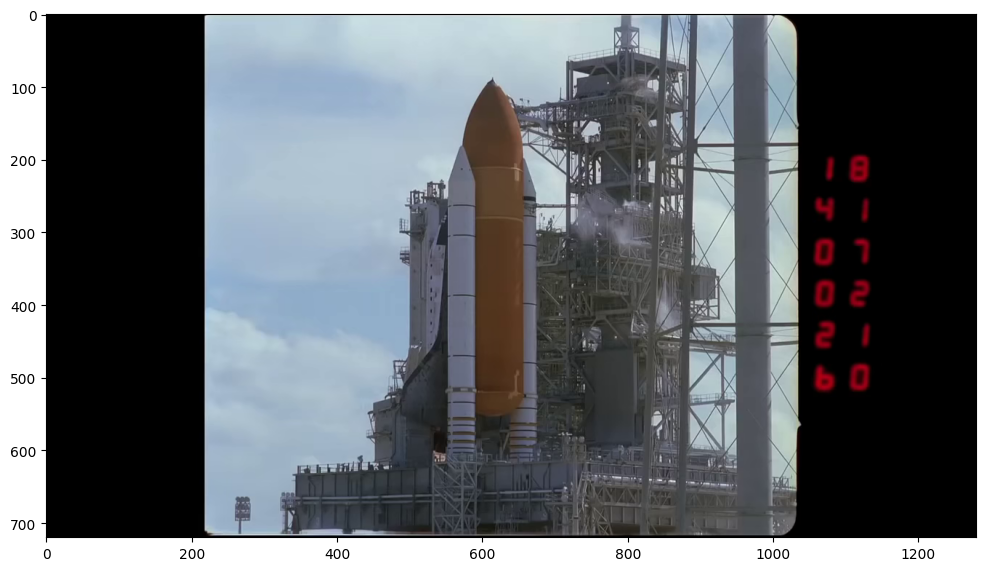

In [59]:
source = cv2.VideoCapture('dane/shuttle.mp4')
status, frame = source.read()
source.release()
plt.subplots(1, 1, figsize=(12,12))[1].imshow(frame[..., ::-1]);

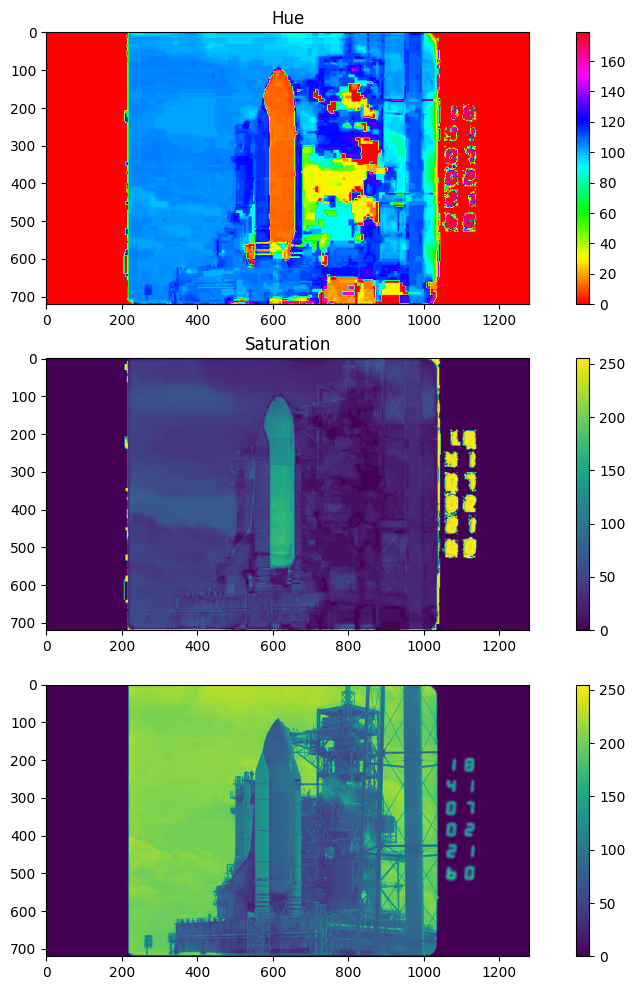

In [69]:
h,s,v = cv2.split(cv2.cvtColor(frame, cv2.COLOR_BGR2HSV))
plt.figure(figsize=(12,12))
plt.subplot(3,1,1)
im = plt.imshow(h, cmap='hsv')
plt.colorbar(im)
plt.title('Hue')
plt.subplot(3,1,2)
im = plt.imshow(s)
plt.colorbar(im)
plt.title('Saturation')
plt.subplot(3,1,3)
im = plt.imshow(v)
plt.colorbar(im)

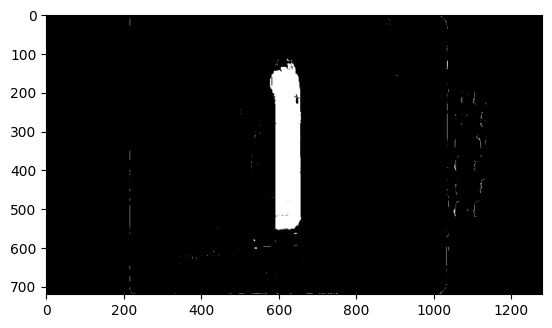

In [80]:
mask = (s > 100) & (s < 180)
plt.imshow(mask, cmap='gray')

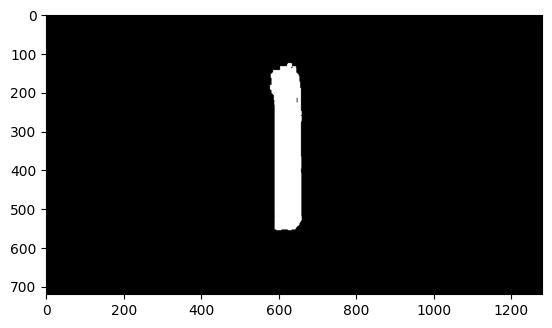

In [87]:
erode = cv2.erode(mask.astype(np.uint8), np.ones((5,5)))
dilate = cv2.dilate(erode, np.ones((9,9)))
plt.imshow(dilate, cmap='gray')

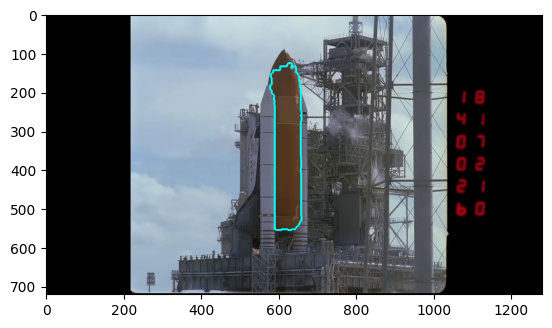

In [91]:
display = frame.copy()
cv2.drawContours(display, contours, -1, (255, 255, 0), 3)
plt.imshow(display[..., ::-1]);

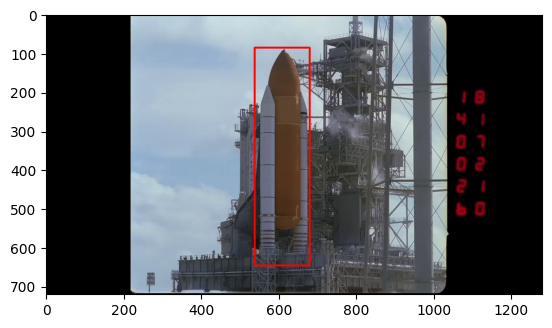

In [117]:
frame_copy = frame.copy()
contours = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
x, y, w, h = cv2.boundingRect(contours[0])
x -= 40
y -= 40
w += 60
h += 130
cv2.rectangle(frame_copy, (x, y), (w+x,h+y), (0,0,255), 4)
plt.imshow(frame_copy[..., ::-1])

In [118]:
mask = np.zeros_like(frame[...,0])
cv2.rectangle(mask, (x, y), (w+x,h+y), (255,255,255), -1);

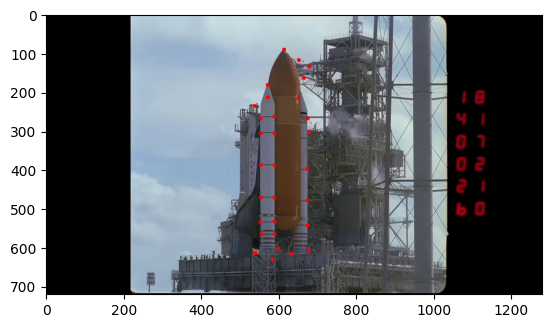

In [129]:
corners = cv2.goodFeaturesToTrack(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), 100, 0.1, 30, mask=mask)
corners = corners.astype(int)
frame_copy = frame.copy()
for corner in corners:
    x, y = corner[0]
    cv2.circle(frame_copy, (x, y), 5, (0, 0, 255), -1)

plt.imshow(frame_copy[..., ::-1]);

### Zadanie 2

Uzupełnij daną poniżej podstawową pętlę analizy wideo o śledzenie obiektów: inicjalizację i wykorzystanie przepływu optycznego do aktualizacji ich położenia. Celem jest pozyskanie pełnej trajektorii pojazdu, tak aby można było ją narysować (np. [`cv2.polylines`](https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#gaa3c25f9fb764b6bef791bf034f6e26f5)) tudzież przetwarzać dalej.

Zapoznaj się dobrze z dokumentacją funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323), zwłaszcza z wartościami zwracanymi, **zwłaszcza** `status`. Upewnij się, że odpowiednio obsługujesz przypadki niepowodzenia znalezienia przepływu dla poszczególnych punktów.

Wynik zaprezentuj w postaci graficznej (narysowane trajektorie).

In [134]:
def baseLoop(source: cv2.VideoCapture, corners: np.ndarray):
    prev_frame = None
    status, frame = source.read()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners = corners.reshape(-1, 1, 2)
    trajectories = np.zeros_like(frame)
    
    points_trajectories = []
    for _ in range(len(corners)):
        points_trajectories.append([])

    while True:
        prev_frame = frame_gray
        status, frame = source.read()
        if not status:
            break
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        next_corners, status, _ = cv2.calcOpticalFlowPyrLK(
            prevImg=prev_frame,
            nextImg=frame_gray,
            prevPts=corners,
            nextPts=None,
        )

        valid_corners = next_corners[status == 1]
        valid_prev_corners = corners[status == 1]

        for i, (prev, curr) in enumerate(zip(valid_prev_corners, valid_corners)):
            x1, y1 = prev.ravel()
            x2, y2 = curr.ravel()
            points_trajectories[i].append((x2, y2))
            cv2.line(trajectories, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

        corners = valid_corners.reshape(-1, 1, 2)
        filtered_trajectories = [traj for traj in points_trajectories if len(traj) > 1]
    plt.figure(figsize=(12, 12))
    plt.imshow(trajectories[..., ::-1])

    return filtered_trajectories
        

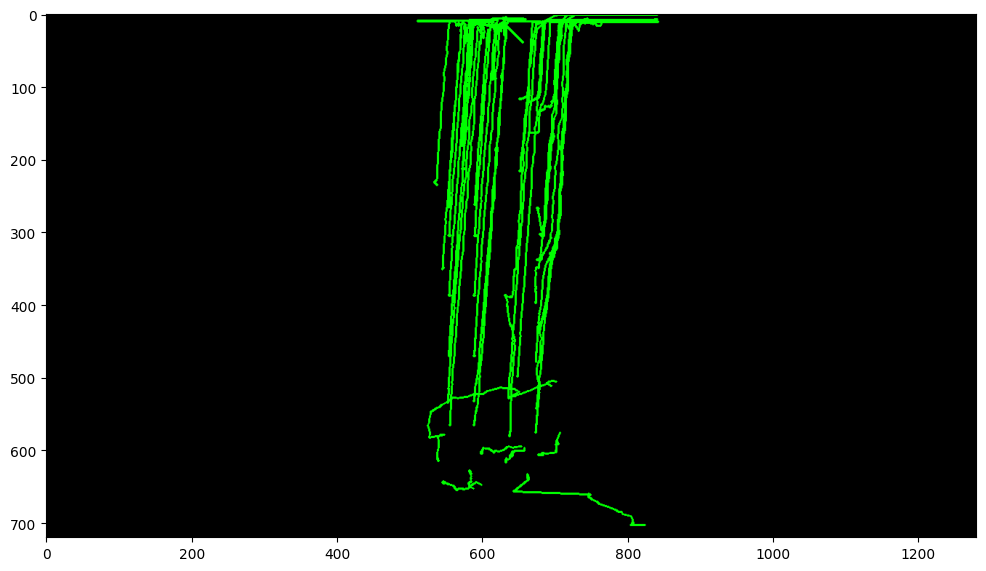

In [135]:
corners = cv2.goodFeaturesToTrack(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), 150, 0.01, 30, mask=mask)
source = cv2.VideoCapture('dane/shuttle.mp4')
trajectories = baseLoop(source, corners)

### Zadanie 3

Dokonaj analizy znalezionych trajektorii i znajdź prędkość _Discovery_.

Wersja minimum: załóż, że pojazd porusza się z lokalnie stałą prędkością.  
Wersja normalna: wykreśl prędkość pojazdu jako funkcję czasu.  
Wersja z plusem: zastosuj odpowiednią filtrację funkcji położenia, by uniezależnić funkcję czasu od szumu.

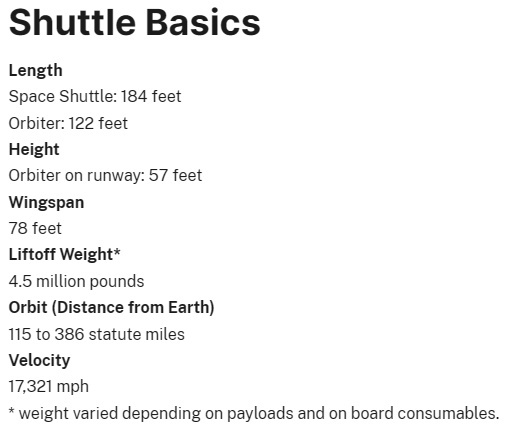

184 feet = 56.0832 m ≈ 56.1 m

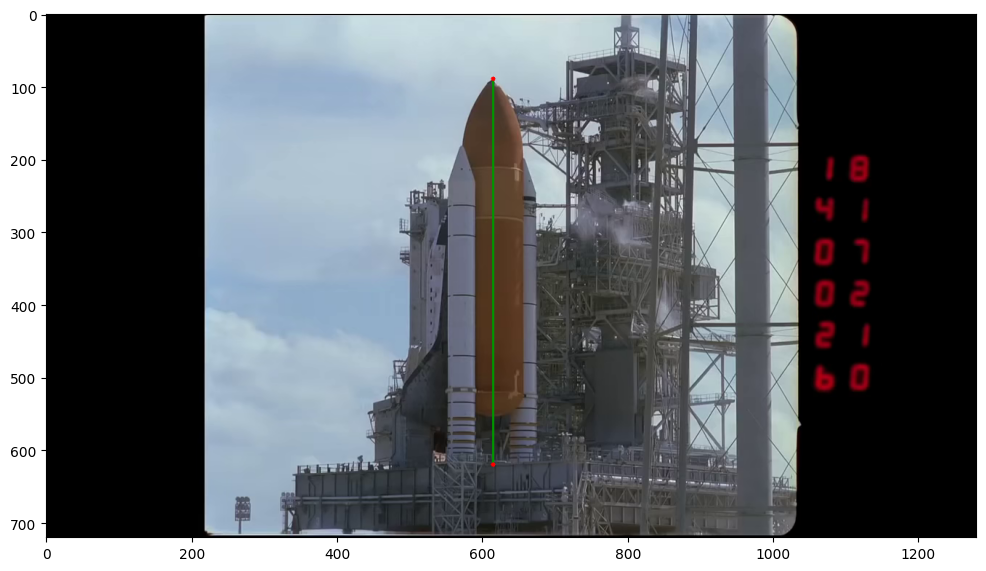

In [56]:
plt.figure(figsize=(12, 12))
frame_copy = frame.copy()
cv2.line(frame_copy, (615, 90), (615, 620), (0, 150, 0), 2)
cv2.circle(frame_copy, (615, 90), 3, (0, 0, 255), -1)
cv2.circle(frame_copy, (615, 620), 3, (0, 0, 255), -1)
plt.imshow(frame_copy[..., ::-1]);

In [145]:
len(trajectories), len(trajectories[0]), len(trajectories[0][0])

(39, 359, 2)

In [137]:
height_px = 620 - 90
height_m = 56.1
scale = height_m / height_px # meters per pixel

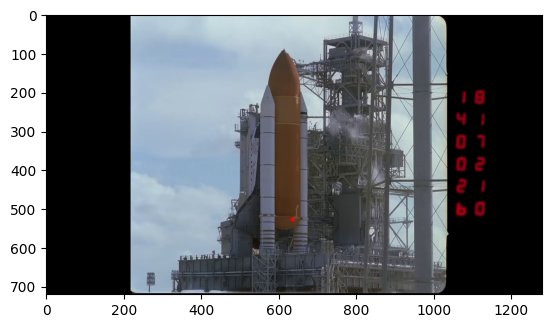

In [229]:
x1, y1 = trajectories[-1][0]
frame_copy = frame.copy()
cv2.circle(frame_copy, (int(x1), int(y1)), 5, (0, 0, 255), -1)
plt.imshow(frame_copy[..., ::-1]);

In [231]:
def get_velocity(trajectories, fps, scale):
    velocities = []
    for i in range(1, len(trajectories)):
        x1, y1 = trajectories[i-1]
        x2, y2 = trajectories[i]
        distance_px = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        distance_m = distance_px * scale
        velocity_m_per_s = distance_m * fps
        velocities.append(velocity_m_per_s)

    time = np.arange(len(velocities)) / fps
    plt.figure(figsize=(12, 6))
    plt.plot(time, velocities, label="Prędkość (m/s)", color='blue')
    plt.xlabel("Czas (s)")
    plt.ylabel("Prędkość (m/s)")
    plt.title("Prędkość wahadłowca Discovery w funkcji czasu")
    plt.legend()
    plt.grid()
    plt.show()

    avg_velocity = np.mean(velocities)
    print(f"Średnia prędkość: {avg_velocity:.2f} m/s")
    return velocities, avg_velocity


In [197]:
cap = cv2.VideoCapture('dane/shuttle.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)

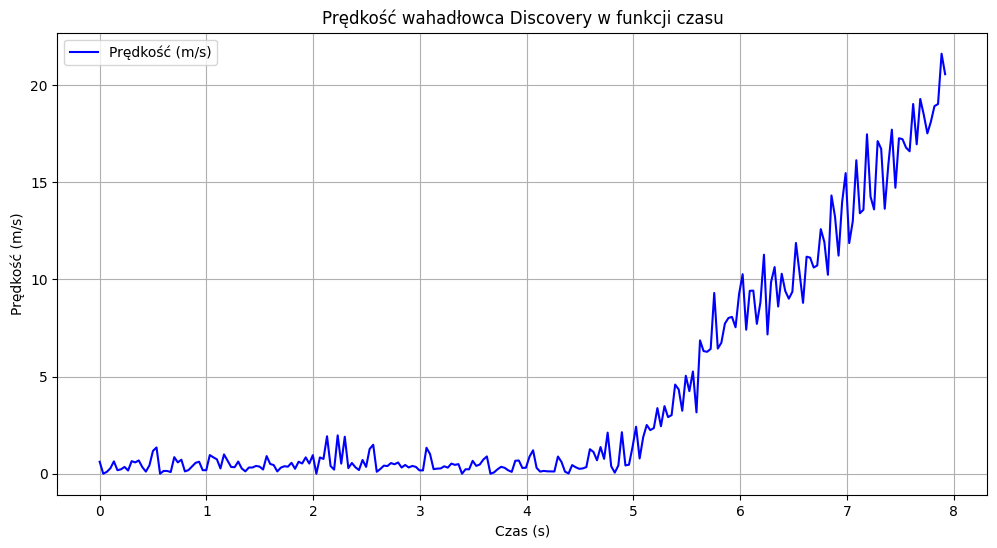

Średnia prędkość: 4.21 m/s


In [232]:
velocities, avg_v = get_velocity(trajectories[-1], fps, scale);